## Appendix:Fifth Analysis —— **CRYPTO NEWS ON DOGECOIN VOLATILITY**

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from datetime import datetime, timedelta
from transformers import pipeline
from pyinform.transferentropy import transfer_entropy
from joblib import Parallel, delayed
import time
from arch import arch_model
import statsmodels.api as sm
from utils.helpers import *
from utils.pipelines import *
from models.classifier import *
from utils.calibration import *
from utils.visualization import *
from utils.constants import Constant

c:\Users\floyd\.conda\envs\big_data\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
C =Constant()

In [3]:
#Merged News data
data = read_file(f"{C.processed_data_dir}final_df.csv")
#Doge price data
doge_price = read_file(f"{C.clean_data_dir}doge_price.parquet").rename({"Date":"date"}, axis = 1)
#Sentiment data is the tesla news sentiment data
#Getting the sentiment data for the analysis
sentiment_data = data

merged_df = process_and_merge_data_continous_price(sentiment_data, doge_price)

#Calculating log returns and then inspecting the return dataframe 
intermediate_data = calculate_log_returns(merged_df,'Open')
intermediate_data.head()

c:\Users\floyd\Desktop\financial-big-data-project\utils\helpers.py:63: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sentiment_data['date'] = sentiment_data['date'].dt.ceil('T')  # 'T' stands for minute


,date,Sentiment,Open,Log_Return
294,2021-11-04 16:32:00+00:00,0.0,0.2571,-0.017352
295,2021-11-05 13:37:00+00:00,0.0,0.2630,0.022689
296,2021-11-05 15:39:00+00:00,-1.0,0.2598,-0.012242
297,2021-11-08 14:44:00+00:00,1.0,0.2761,0.060851
298,2021-11-08 20:00:00+00:00,0.0,0.2815,0.019369


First, we estimate the **volatility process** with a GARCH(3,1) process after calculating the log returns as below:

$$
r_t = \mu + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma_t^2), \quad \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \alpha_3 \epsilon_{t-3}^2 + \beta \sigma_{t-1}^2
$$


Set the volatility of the stock as **tranquil**, **steady** and **crisis** under a threshold and label it as (1,0,-1). Then we construct a stochastic process for stock volatility. The formula for the stochastic process of the discretized volatility can be written as: 

$$
\sigma_{t}^{s'} = h(\sigma_{t}^{s}), 

h(x) = \begin{cases}1, x > \gamma \\ 0, \|x\| \leq \gamma \\ -1, x < -\gamma\end{cases},

\gamma, \delta > 0
$$

 - $\sigma_{t}^{s}$ is the estimated volatility of stock $s$ at time $t$ by GARCH(3,1)
 - $\sigma_{t}^{s'}$ is the discritized process of estimated volatility of stock $s$ at time $t$ by GARCH(3,1)

In [4]:
# Fit a GARCH(3,1) model
am = arch_model(intermediate_data['Log_Return'], vol='GARCH', p=3, q=1, dist='normal')
res = am.fit(disp='off')
# Extract the fitted conditional volatilities (time series)
intermediate_data['garch_vol'] = res.conditional_volatility

C:\Users\floyd\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001186. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\floyd\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [5]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                52299.2
Distribution:                  Normal   AIC:                          -104586.
Method:            Maximum Likelihood   BIC:                          -104541.
                                        No. Observations:                15538
Date:                Sat, Jan 25 2025   Df Residuals:                    15537
Time:                        18:38:17   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.6547e-05  8.311e-05     -0.801      0.

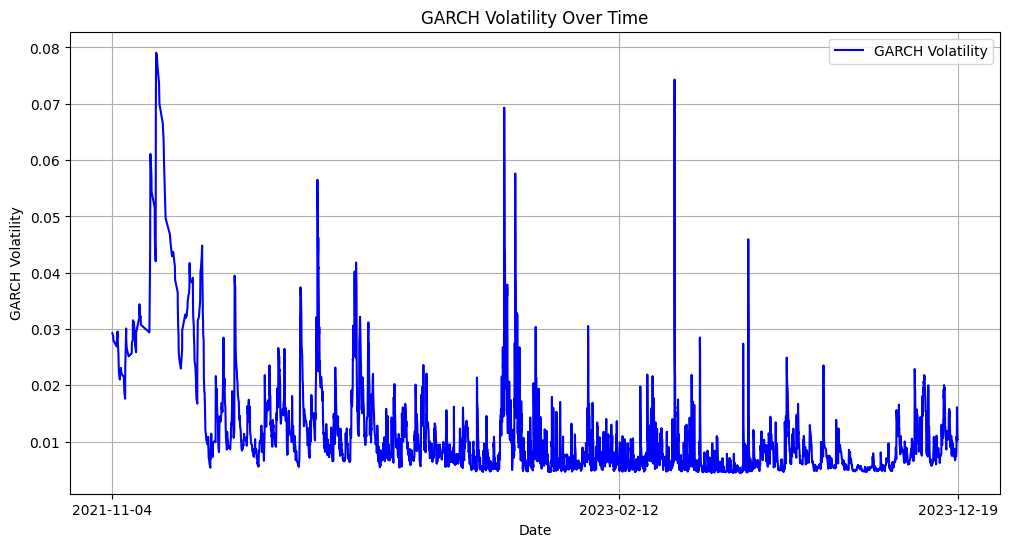

In [6]:
# Convert Date to datetime format with dayfirst=True
intermediate_data['date'] = pd.to_datetime(intermediate_data['date'], dayfirst=True)

# Determine the first, middle, and last date for x-ticks
first_date = intermediate_data['date'].iloc[0]
middle_date = intermediate_data['date'].iloc[len(intermediate_data) // 2]
last_date = intermediate_data['date'].iloc[-1]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(intermediate_data['date'], intermediate_data['garch_vol'], label='GARCH Volatility', color='blue')

# Customizing the x-axis ticks
plt.xticks([first_date, middle_date, last_date], 
           [first_date.strftime('%Y-%m-%d'), 
            middle_date.strftime('%Y-%m-%d'), 
            last_date.strftime('%Y-%m-%d')])

# Adding labels, title, and legend
plt.xlabel('Date')
plt.ylabel('GARCH Volatility')
plt.title('GARCH Volatility Over Time')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


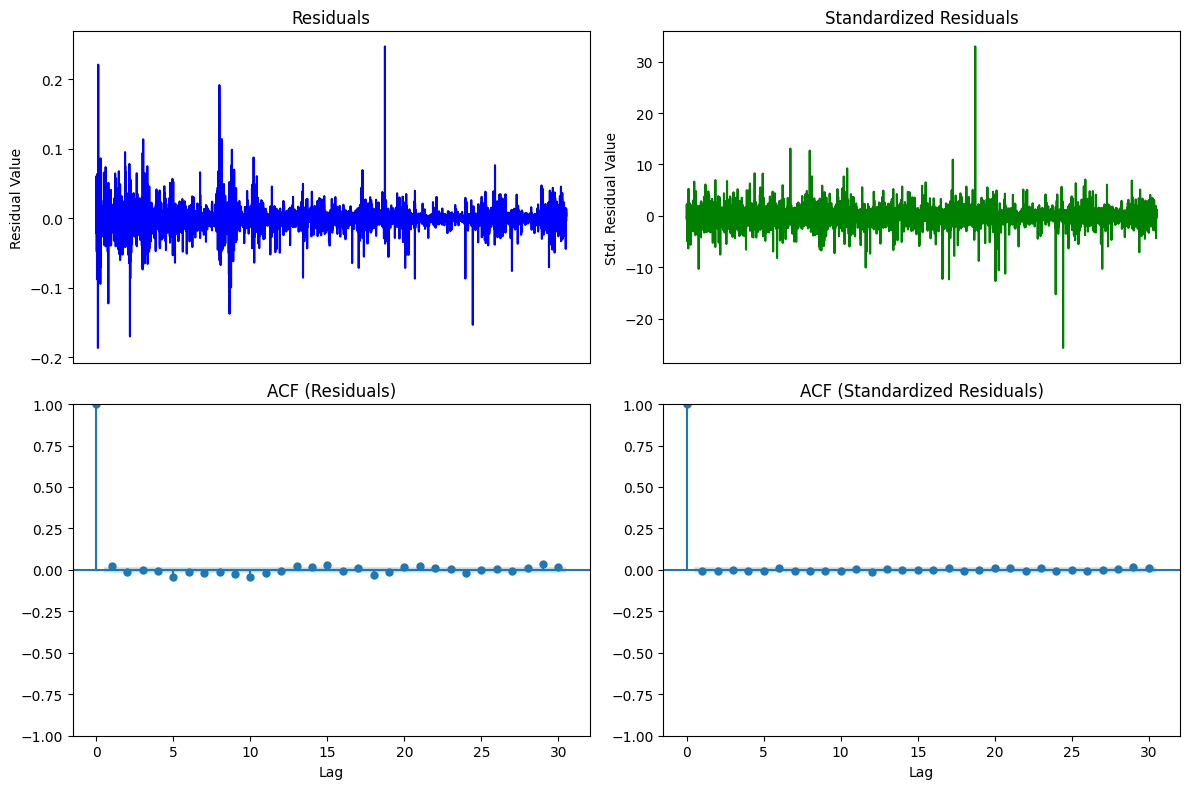

In [7]:
# Extract residuals (epsilon), conditional vol, and standardized residuals
residuals = res.resid
conditional_vol = res.conditional_volatility
standardized_residuals = residuals / conditional_vol

# ----- Plot Setup -----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Residuals vs time
axes[0, 0].plot(residuals.index, residuals, label='Residuals', color='blue')
axes[0, 0].set_title("Residuals")
axes[0, 0].set_xlabel("")  # Remove x-label
axes[0, 0].set_ylabel("Residual Value")
axes[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 2. Standardized residuals vs time
axes[0, 1].plot(standardized_residuals.index, standardized_residuals, label='Std Residuals', color='green')
axes[0, 1].set_title("Standardized Residuals")
axes[0, 1].set_xlabel("")  # Remove x-label
axes[0, 1].set_ylabel("Std. Residual Value")
axes[0, 1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Remove x-ticks

# 3. ACF of residuals (move this to the bottom-left position)
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=30, ax=axes[1, 0])
axes[1, 0].set_title("ACF (Residuals)")
axes[1, 0].set_xlabel("Lag")  # Add x-label

# 4. ACF of standardized residuals (move this to the bottom-right position)
sm.graphics.tsa.plot_acf(standardized_residuals.dropna(), lags=30, ax=axes[1, 1])
axes[1, 1].set_title("ACF (Standardized Residuals)")
axes[1, 1].set_xlabel("Lag")  # Add x-label

plt.tight_layout()
plt.show()


